# Psuedo-Surge Simulation of Synthetic Little Kluane  


Before we figure out the best way to prescribe sliding in `Elmer` let's first take some time to understand how sliding in prescribed in `Elmer`. 
In `Elmer/Ice` the default sliding law is of the form: 
$$
\tau = \beta^2 u
$$
where $\tau$ is traction (i.e. basal shear stress), $u$ is velocity in the tangetial plane, and $\beta^{-2}$ is the slip coefficent. Let's use some example values from Cuffey and Patterson to look into units, and how we will need to scale to `Elmer/Ice` base units of MPa, a, m. 
Note, Cuffey and Patterson use a simpler measure of lubrication with an apparent drag factor, $\psi$, a positive number
defined by
$$
\tau_b = \psi u_b
$$
for a basal shear stress $\tau_b$, and rate of slip $u_b$.
Values listed below come from Table 7.2 in Cuffey and Patterson

|    Glacier    | $\tau_b$ <br>(kPa) | $u_b$ <br>(m y$^{-1}$) | $\psi$<br>(kPa (m y$^{-1}$)$^{-1}$) |
|:-------------:|:------------------:|:----------------------:|:-----------------------------------:|
|   Trapridge   |         80         |           30           |        $\approx$ 3                  |
| Storglaciären |         40         |           30           |        $\approx$ 1                  |

So, let's begin by scaling these example parameter values to `Elmer/Ice` base units (MPa, a, m): 

|    Glacier    | $\tau_b$ <br>(MPa) | $u_b$ <br>(m y$^{-1}$) | $\psi$<br>(kPa (m y$^{-1}$)$^{-1}$) |
|:-------------:|:------------------:|:----------------------:|:-----------------------------------:|
|   Trapridge   |         8e-2       |           30           |       $\approx$ 3e-3                |
| Storglaciären |         4e-2       |           30           |       $\approx$ 1e-3                |


Great! Now we can see from these two simple formulations: 
$$
\beta = \sqrt{\psi}
$$

Let's use our inital conditions (i.e. $z_s$ and $z_b$) to figure out the corresponding value of $\beta$ for some set value of $u_b$. To do this we will need to make an approximation of $\tau_b$ using the approximation: 

$$
\tau_b = \rho g H \sin \alpha
$$

where $\rho$ is the ice density, $g$ is the acceleration due to gravity, and $\alpha$ is the suface slope. 

First, lets make sure our units are going to be correct during these back of the envelope calculations: 

In [1]:
import pint 
import numpy as np 
import matplotlib.pyplot as plt 
ureg = pint.UnitRegistry()

#############################################
# units
#############################################
a   = ureg.year             # [a]
s   = ureg.sec              # [s]
m   = ureg.meter            # [m]
kg  = ureg.kilogram         # [kg]
kPa = ureg('kPa')           # [kPa]
MPa = ureg('MPa')           # [MPa]

#############################################
# parameters (S.I. units)
#############################################
spy   = 365.25*24*60*60 * (s/a)                    # [s a^-1]
ρ     = 910             * (kg*m**-3)               # [Kg m^-3]
g     = 9.81            * (m*s**-2)                # [m s^-2]

#############################################
# parameters (Elmer/Ice)
#############################################
ρ     = ρ * (MPa/MPa.to_base_units()) * spy**-2    # [MPa m^-2 a^2] <--[Kg m^-3]
g     = g * spy**2                                 # [m a^-2] <--------[m s^-2]

Great. Let's now read in our inital conditions and assign the appropraite units: 

In [2]:
x_c = np.loadtxt('../Data/SurfTopo.dat')[:,0]    # x-coordinate
z_s = np.loadtxt('../Data/SurfTopo.dat')[:,1]    # surface elevation (m a.s.l.)
z_b = np.loadtxt('../Data/BedTopo.dat')[:,1]     # bed evelation (m a.s.l.)

H      = (z_s - z_b) * m                         # Ice thickness (m)
α      = np.zeros_like(H) * m/m                  # Surface slope (m/m)
# Surface slope only valid where H>0
α[H>0] = np.gradient(z_s[H>0], x_c[H>0])         

Now let's solve for the approximation of the basal shear stress ($\tau_b$) for "synthetic" little Kluane 

In [3]:
# Approximation of the basal shear stress for LK
𝜏 = ρ*g*H*np.sin(α)

Now let's solve for the $\beta$ corresponding to $u_b$ = 365 (m a$^{-1}$) or 1 (m d$^{-1}$). 

In [4]:
β_sqaured = 𝜏 / (365. * m /a)

In [5]:
np.mean(β_sqaured[β_sqaured>0.0])

0.00043677711991891514 <Unit('megapascal * year / meter')>

In [6]:
β_sqaured

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.44137606e-05, 1.43467012e-04, 2.10483937e-04,
       2.63123790e-04, 2.99912375e-04, 3.22305266e-04, 3.56489157e-04,
       3.85789636e-04, 3.89759738e-04, 4.08319725e-04, 4.17664141e-04,
       4.09053015e-04, 4.23587894e-04, 4.33969950e-04, 4.46428418e-04,
       4.05008227e-04, 4.14171309e-04, 4.26999624e-04, 4.37995322e-04,
       4.52656253e-04, 4.37926079e-04, 4.53321918e-04, 4.36875537e-04,
       4.51173282e-04, 4.63882388e-04, 4.73414218e-04, 4.81357410e-04,
       4.48775980e-04, 4.50242568e-04, 4.50242568e-04, 4.50242568e-04,
       4.54642333e-04, 4.20828926e-04, 4.22173427e-04, 4.64908450e-04,
       4.28895934e-04, 4.28895934e-04, 4.32929438e-04, 4.36962942e-04,
       4.42340947e-04, 4.53096958e-04, 4.65197471e-04, 4.36389995e-04,
       4.48613804e-04, 5.02843509e-04, 5.09566015e-04, 4.66949518e-04,
       4.64504756e-04, 4.57170470e-04, 4.93431999e-04, 4.81331487e-04,
       4.30278090e-04, 4.26610947e-04, 4.29055709e-04, 4.33945233e-04,
       4.41279518e-04, 4.47391423e-04, 4.54725709e-04, 4.14786693e-04,
       4.16987153e-04, 4.66949518e-04, 4.71839042e-04, 4.76728565e-04,
       4.34590832e-04, 4.37891522e-04, 4.90174756e-04, 4.46693362e-04,
       4.48893821e-04, 4.52194511e-04, 4.54394971e-04, 4.53294741e-04,
       4.00023050e-04, 4.42292442e-04, 4.35691062e-04, 3.78505917e-04,
       3.68725403e-04, 4.04884623e-04, 3.97183014e-04, 3.48186322e-04,
       3.46230219e-04, 3.49164373e-04, 3.10673015e-04, 3.17519804e-04,
       3.75571763e-04, 3.89264484e-04, 4.02957204e-04, 3.63735624e-04,
       3.72294109e-04, 4.34254851e-04, 3.85987686e-04, 3.88555231e-04,
       3.90266928e-04, 3.89411080e-04, 3.87699383e-04, 3.84275989e-04,
       3.80852594e-04, 3.75717503e-04, 3.71438261e-04, 3.13991154e-04,
       3.62879775e-04, 3.62879775e-04, 3.62879775e-04, 3.65447321e-04,
       3.67159018e-04, 3.70582412e-04, 3.72294109e-04, 4.28386542e-04,
       3.76573352e-04, 3.75717503e-04, 4.25452388e-04, 4.21540182e-04,
       3.62879775e-04, 3.56888836e-04, 4.01979153e-04, 4.45593132e-04,
       4.40091982e-04, 3.85352278e-04, 3.80462020e-04, 4.22488303e-04,
       4.64504756e-04, 4.14786693e-04, 4.08185313e-04, 4.42501899e-04,
       4.25388566e-04, 3.98496185e-04, 3.69159043e-04, 3.69737874e-04,
       3.36125340e-04, 3

Using Eriks code as staring place, lets spin-up some transient simulations with pseudo-surges. 

Here's the `MATC` code Erik uses to describe space and time dependent slip coefficent:
```
  Slip Coefficient 2 = Variable TimeStep, Coordinate 1, Coordinate 2
        Real MATC "if (tx(1) > 15000) (0.01); 
        if (tx(2) < 14000) (0.01); 
        if (0.995 < sin((tx(0)-10.0)*0.1)) ((-tx(0)+26.0)*0.0001); 
        else (0.01);"
```

In `Elmer/Ice` the default sliding law is of the form: 
$$
\tau = \beta^2 u
$$
where $\tau$ is traction (i.e. basal shear stress), $u$ is velocity in the tangetial plane, and $\beta^{-2}$ is the slip coefficent. 

In [7]:
import numpy as np 
import matplotlib.pyplot as plt

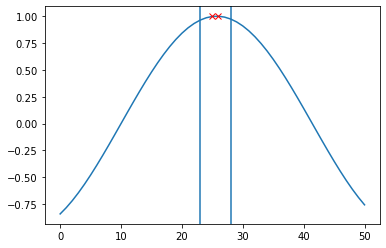

In [8]:
# time vector (a)
t = np.linspace(0,50,51)
# Slip coefficent 
β = np.sin((t-10.0)*0.1)
plt.plot(t, np.sin((t-10.0)*0.1))
plt.plot(t[0.995 < β], β[0.995 < β], 'rx')

plt.axvline(23)
plt.axvline(28)

In [9]:
x_c = np.loadtxt('../Data/SurfTopo.dat')[:,0]
z_s = np.loadtxt('../Data/SurfTopo.dat')[:,1]
z_b = np.loadtxt('../Data/BedTopo.dat')[:,1]

H      = z_s - z_b
a      = np.zeros_like(H)
a[H>0] = np.gradient(z_s[H>0], x_c[H>0])

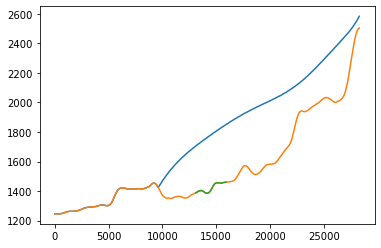

In [10]:
plt.plot(x_c,z_s)
plt.plot(x_c,z_b)

plt.plot(x_c[(x_c>13000) & (x_c<16000)], z_b[(x_c>13000) & (x_c<16000)])

In [ ]:
t = np.linspace(1,10,100)
β = np.zeros(t.shape[0])

In [ ]:
for i, timestep in enumerate(t): 
    if timestep < 5.5: 
        β[i] = ((0.1-1.0)/(4.5)) * timestep + 1.2
        #print(timestep)
    else: 
        β[i] = -((0.1-1.0)/(4.5)) * timestep - 1.0

In [ ]:
β

In [ ]:
plt.plot(t, β)

In [ ]:
beta = np.ones((x_c.shape[0], t.shape[0]))*0.01

In [ ]:
beta[(x_c>18000), (0.995 < np.sin((t-10.0)*0.1))] = 0.001

In [ ]:
for i, j in enumerate(t):
    if (0.995 < np.sin((j-10.0)*0.1)): 
        
        beta[(x_c>18000),i] = (-j+26.0)*0.001

In [ ]:
10 - 5.5